<a href="https://colab.research.google.com/github/myracheng/tcav/blob/master/new_tcav_inaturalist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# imports


In [0]:
!pip install dropbox
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import cv2
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import json
from zipfile import ZipFile 
import dropbox
import torch
import shutil
from os.path import join
from glob import glob
from PIL import Image
import time
from imageio import imread
from multiprocessing import dummy as multiprocessing
import sys
import scipy.stats as stats
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import skimage.segmentation as segmentation
import sklearn.cluster as cluster
import sklearn.metrics.pairwise as metrics
import tensorflow as tf
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
!git clone https://github.com/myracheng/tcav.git
dbx = dropbox.Dropbox(access_token)
  

     |████████████████████████████████| 552kB 2.8MB/s 


Cloning into 'tcav'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 31 (delta 0), reused 1 (delta 0), pack-reused 28
Unpacking objects: 100% (31/31), done.


# Load data in

In [0]:
# !pip install dropbox
!mkdir  -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download inaturalist-2019-fgvc6 -f train_val2019.tar.gz --force


 12% 9.12G/73.1G [03:28<24:23, 46.9MB/s]
User cancelled operation


In [0]:
!tar -xf /content/train_val2019.tar.gz
!rm train_val2019.tar.gz
!kaggle competitions download inaturalist-2019-fgvc6 -f train2019.json --force
file_name = "train2019.json.zip"
  
# # opening the zip file in READ mode 
with ZipFile(file_name, 'r') as zipF: 
    print('Extracting all the files now...') 
    data = zipF.extract('train2019.json') 
    print('Done!')
    ann_file = 'train2019.json'
with open(ann_file) as data_file:
        train_anns = json.load(data_file)
train_anns_df = pd.DataFrame(train_anns['annotations'])[['image_id','category_id']]
train_img_df = pd.DataFrame(train_anns['images'])[['id', 'file_name']].rename(columns={'id':'image_id'})
df_train_file_cat = pd.merge(train_img_df, train_anns_df, on='image_id')
df_train_file_cat['category_id']=df_train_file_cat['category_id'].astype(str)
df_train_file_cat.head()
metadata, res = dbx.files_download('/categories.json.tar.gz')

with open('categories.json.tar.gz', "wb") as f:
  f.write(res.content)
!tar -xf /content/categories.json.tar.gz
cat_file = 'categories.json'
with open(cat_file) as data_file:
        cats = json.load(data_file)
species = pd.DataFrame(cats)
!rm categories.json.tar.gz

#load model
metadata, res = dbx.files_download('/inat_model')

with open('inat_model', "wb") as f:
  f.write(res.content)
the_model = torch.load('inat_model')

In [0]:
metadata, res = dbx.files_download('/categories.json.tar.gz')

with open('categories.json.tar.gz', "wb") as f:
  f.write(res.content)
!tar -xf /content/categories.json.tar.gz
cat_file = 'categories.json'
with open(cat_file) as data_file:
        cats = json.load(data_file)
species = pd.DataFrame(cats)
!rm categories.json.tar.gz

#load model
metadata, res = dbx.files_download('/inat_model')

with open('inat_model', "wb") as f:
  f.write(res.content)
the_model = torch.load('inat_model')

In [0]:
shutil.rmtree('train_val2019/Amphibians')
shutil.rmtree('train_val2019/Fungi')

In [0]:

the_model = torch.load('../inat_model')

# Species Viz

In [0]:
species.where(species['id'].isin(np.arange(26)) ).dropna()

,kingdom,phylum,name,family,genus,order,id,class
0,Fungi,Basidiomycota,Amanita vaginata,Amanitaceae,Amanita,Agaricales,0.0,Agaricomycetes
1,Fungi,Basidiomycota,Amanita flavoconia,Amanitaceae,Amanita,Agaricales,1.0,Agaricomycetes
2,Fungi,Basidiomycota,Amanita calyptroderma,Amanitaceae,Amanita,Agaricales,2.0,Agaricomycetes
3,Fungi,Basidiomycota,Amanita jacksonii,Amanitaceae,Amanita,Agaricales,3.0,Agaricomycetes
4,Fungi,Basidiomycota,Amanita phalloides,Amanitaceae,Amanita,Agaricales,4.0,Agaricomycetes
5,Fungi,Basidiomycota,Amanita muscaria,Amanitaceae,Amanita,Agaricales,5.0,Agaricomycetes
6,Fungi,Basidiomycota,Amanita bisporigera,Amanitaceae,Amanita,Agaricales,6.0,Agaricomycetes
7,Fungi,Basidiomycota,Amanita gemmata,Amanitaceae,Amanita,Agaricales,7.0,Agaricomycetes
8,Fungi,Basidiomycota,Amanita pantherina,Amanitaceae,Amanita,Agaricales,8.0,Agaricomycetes
9,Fungi,Basidiomycota,Amanita velosa,Amanitaceae,Amanita,Agaricales,9.0,Agaricomycetes


In [0]:
species.where(species['id'].isin(np.arange(5,6)) ).dropna()

,kingdom,phylum,name,family,genus,order,id,class
5,Fungi,Basidiomycota,Amanita muscaria,Amanitaceae,Amanita,Agaricales,5.0,Agaricomycetes


In [0]:
species.where(species['id'].isin(np.arange(54,55)) ).dropna()

,kingdom,phylum,name,family,genus,order,id,class
54,Animalia,Arthropoda,Libellula incesta,Libellulidae,Libellula,Odonata,54.0,Insecta


In [0]:
species.where(species['id'].isin(np.arange(25,26)) ).dropna()

,kingdom,phylum,name,family,genus,order,id,class
25,Animalia,Arthropoda,Argia plana,Coenagrionidae,Argia,Odonata,25.0,Insecta


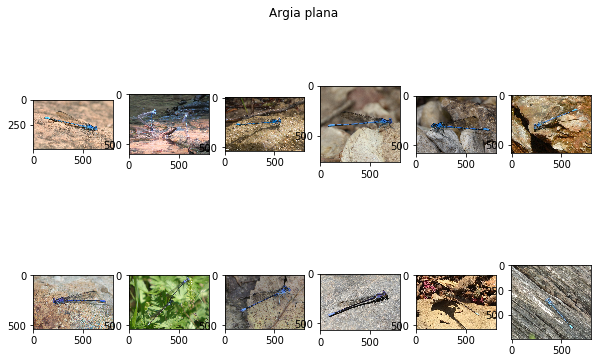

In [0]:
cat = 25
img_names = df_train_file_cat[df_train_file_cat['category_id']==str(cat)]['file_name'][:12]
# img_names
plt.figure(figsize=[10,6])
i = 1
for img_name in img_names:
    img = cv2.imread("%s" % img_name)[...,[2, 1, 0]]
    plt.subplot(2,6, i)
    plt.imshow(img)
    i += 1
name = np.array((species.where(species['id']==cat).dropna()['name']))
plt.suptitle(name[0])
plt.show()

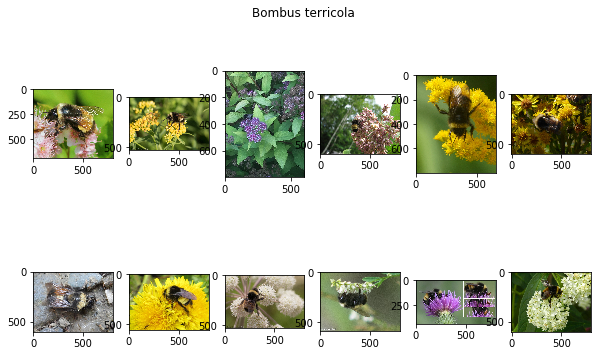

In [0]:
cat = 115
img_names = df_train_file_cat[df_train_file_cat['category_id']==str(cat)]['file_name'][:12]
# img_names
plt.figure(figsize=[10,6])
i = 1
for img_name in img_names:
    img = cv2.imread("%s" % img_name)[...,[2, 1, 0]]
    plt.subplot(2,6, i)
    plt.imshow(img)
    i += 1
name = np.array((species.where(species['id']==cat).dropna()['name']))
plt.suptitle(name[0])
plt.show()

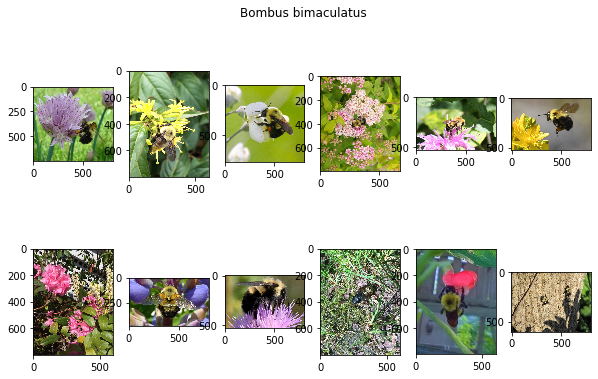

In [0]:
cat = 127
img_names = df_train_file_cat[df_train_file_cat['category_id']==str(cat)]['file_name'][:12]
# img_names
plt.figure(figsize=[10,6])
i = 1
for img_name in img_names:
    img = cv2.imread("%s" % img_name)[...,[2, 1, 0]]
    plt.subplot(2,6, i)
    plt.imshow(img)
    i += 1
name = np.array((species.where(species['id']==cat).dropna()['name']))
plt.suptitle(name[0])
plt.show()

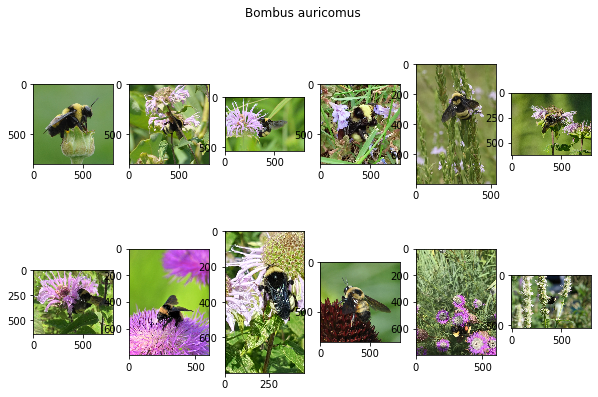

In [0]:
cat = 133
img_names = df_train_file_cat[df_train_file_cat['category_id']==str(cat)]['file_name'][:12]
# img_names
plt.figure(figsize=[10,6])
i = 1
for img_name in img_names:
    img = cv2.imread("%s" % img_name)[...,[2, 1, 0]]
    plt.subplot(2,6, i)
    plt.imshow(img)
    i += 1
name = np.array((species.where(species['id']==cat).dropna()['name']))
plt.suptitle(name[0])
plt.show()

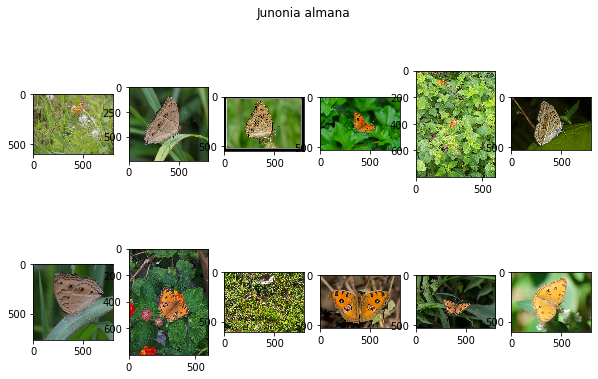

In [0]:
cat = 86
img_names = df_train_file_cat[df_train_file_cat['category_id']==str(cat)]['file_name'][:12]
# img_names
plt.figure(figsize=[10,6])
i = 1
for img_name in img_names:
    img = cv2.imread("%s" % img_name)[...,[2, 1, 0]]
    plt.subplot(2,6, i)
    plt.imshow(img)
    i += 1
name = np.array((species.where(species['id']==cat).dropna()['name']))
plt.suptitle(name[0])
plt.show()

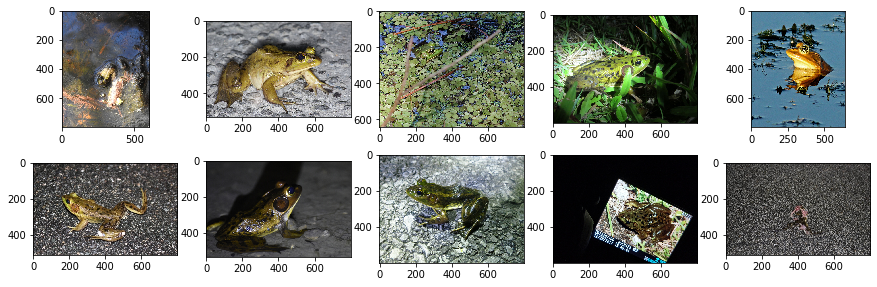

In [0]:
# Example of images for category_id = 153
img_names = df_train_file_cat[df_train_file_cat['category_id']=='154']['file_name'][:10]
# img_names
plt.figure(figsize=[15,15])
i = 1
for img_name in img_names:
    img = cv2.imread("%s" % img_name)[...,[2, 1, 0]]
    plt.subplot(6, 5, i)
    plt.imshow(img)
    i += 1
plt.show()

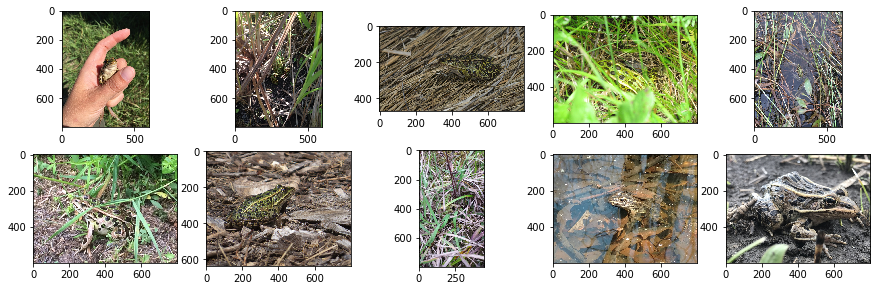

In [0]:
# Example of images for category_id = 153
img_names = df_train_file_cat[df_train_file_cat['category_id']=='158']['file_name'][:10]
# img_names
plt.figure(figsize=[15,15])
i = 1
for img_name in img_names:
    img = cv2.imread("%s" % img_name)[...,[2, 1, 0]]
    plt.subplot(6, 5, i)
    plt.imshow(img)
    i += 1
plt.show()

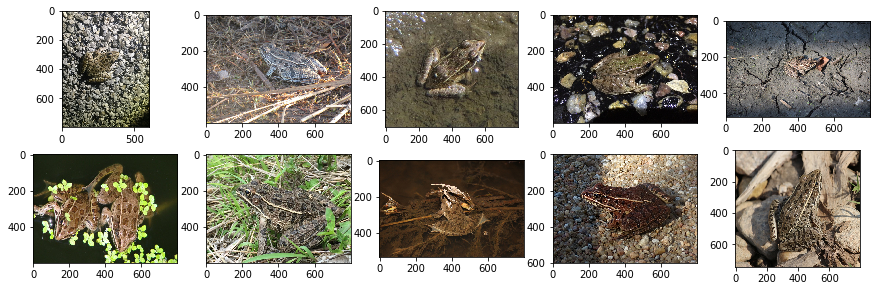

In [0]:
# Example of images for category_id = 153
img_names = df_train_file_cat[df_train_file_cat['category_id']=='162']['file_name'][:10]
# img_names
plt.figure(figsize=[15,15])
i = 1
for img_name in img_names:
    img = cv2.imread("%s" % img_name)[...,[2, 1, 0]]
    plt.subplot(6, 5, i)
    plt.imshow(img)
    i += 1
plt.show()

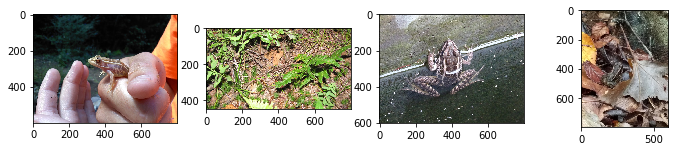

In [0]:
# Example of images for category_id = 153
img_names = df_train_file_cat[df_train_file_cat['category_id']=='159']['file_name'][:4]
# img_names
plt.figure(figsize=[15,15])
i = 1
for img_name in img_names:
    img = cv2.imread("%s" % img_name)[...,[2, 1, 0]]
    plt.subplot(6, 5, i)
    plt.imshow(img)
    i += 1
plt.show()

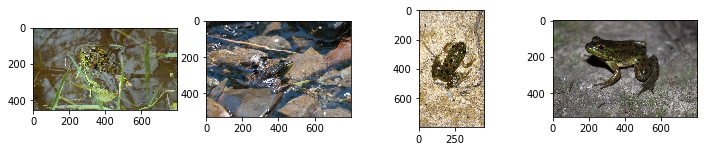

In [0]:
# Example of images for category_id = 153
img_names = df_train_file_cat[df_train_file_cat['category_id']=='157']['file_name'][:4]
# img_names
plt.figure(figsize=[15,15])
i = 1
for img_name in img_names:
    img = cv2.imread("%s" % img_name)[...,[2, 1, 0]]
    plt.subplot(6, 5, i)
    plt.imshow(img)
    i += 1
plt.show()

# Set up folders



In [0]:
os.chdir('..')
shutil.rmtree('tcav_source')

In [0]:
folder_name = 'tcav_source'
def absoluteFilePaths(directory):
  s = []
  for dirpath,_,filenames in os.walk(directory):
      for f in filenames:
        s.append(os.path.abspath(os.path.join(dirpath, f)))
  return s
s = absoluteFilePaths('train_val2019')
if not os.path.isdir(folder_name):
  os.mkdir(folder_name)

In [0]:
# np.random.seed(93)
num_imgs = 20  #todo 30
num_rand_exp = 3 #todo 20
inds = np.random.permutation(s)

for i in range(num_rand_exp):
  new_folder = folder_name + '/random%d_%d'%(500,i)
  if not os.path.isdir(new_folder):
    os.mkdir(new_folder)
  for j in range(num_imgs*i, num_imgs*(i+1)):
    shutil.copy(inds[j], new_folder)
# np.random.seed(94)
max_imgs = 20 #todo 40
inds = np.random.permutation(s)
new_folder = folder_name + '/random_disc'
if not os.path.isdir(new_folder):
  os.makedirs(new_folder)
for j in range(max_imgs):
  shutil.copy(inds[j], new_folder)

In [0]:
for i in [86,115,25]:
  img_names = df_train_file_cat[df_train_file_cat['category_id']==str(i)]['file_name']
  new_folder = folder_name + '/' + str(i)
  if not os.path.isdir(new_folder):
    os.mkdir(new_folder)
  i = 1
  for img_name in img_names[:num_imgs]:
    try:
      shutil.copy(img_name, new_folder)
      i += 1
    except FileNotFoundError:
      continue

In [0]:
len([134,38,54,5,153,158])

6

In [0]:
for i in [134,38,54,5,154,158]:
  img_names = df_train_file_cat[df_train_file_cat['category_id']==str(i)]['file_name']
  new_folder = folder_name + '/' + str(i)
  if not os.path.isdir(new_folder):
    os.mkdir(new_folder)
  i = 1
  for img_name in img_names[:num_imgs]:
    try:
      shutil.copy(img_name, new_folder)
      i += 1
    except FileNotFoundError:
      continue

In [0]:
df_temp = df_train_file_cat['category_id'].apply(pd.to_numeric)
df_temp.head()
np.savetxt('img_labels.txt', df_temp.values,fmt='%d')

## Concept folders

In [0]:
folder_name = 'tcav_source'

In [0]:
shutil.rmtree('tcav_source')


In [0]:
metadata, res = dbx.files_download('/concepts.zip')
with open('concepts.zip', "wb") as f:
  f.write(res.content)
  file_name = "concepts.zip"
# # opening the zip file in READ mode 
with ZipFile(file_name, 'r') as zipF: 
    print('Extracting all the files now...') 
    data = zipF.extractall('tcav_source')
    print('Done!')

Extracting all the files now...
Done!


In [0]:
concept_files = []
concept_files.extend(glob("tcav_source/concepts/*"))
for fol in concept_files:
  new_path ='tcav_source/'
  # shutil.rmtree(new_path)
  # print(new_path)
  # if not os.path.isdir(new_path):
  #   os.mkdir(new_path)
  shutil.move(fol,new_path)  

Error: ignored

In [0]:
#colors
colors = ['green', 'red', 'gray', 'brown']
cd = {'green':[(34,139,34), (0,128,0), (0,100,0)], 'red':[(255,0,0), (139,0,0),  (128,0,0)], 
      'gray':[(169,169,169),(128,128,128),(105,105,105)],'brown':[(205,133,63),(139,69,19),(160,82,45)]}
for c in colors:
  if not os.path.isdir(folder_name + '/' + c):
    os.mkdir(folder_name + '/' + c)
  i = 0
  for tup in cd[c]:
    superpixel = np.ones((299,299,3))
    for j in range(3):
      superpixel[:,:,j] *= tup[j]
    im = Image.fromarray(superpixel.astype(np.uint8))
    im.save(folder_name + '/' + c + "/%s_%d.jpg"%(c,i))
    i += 1

In [0]:
#  similar classes, leopard spots and other textures, habitats, extracting patches
names = ['lake','rocks','mountain','leopardspots']
for n in names:
  metadata, res = dbx.files_download('/%s.txt'%n)

  with open('%s.txt'%n, "wb") as f:
    f.write(res.content)

  file1 = open("%s.txt"%n,"r+")  
  urls = file1.read().splitlines()
  # print(urls)
  if not os.path.isdir(folder_name + '/' + n):
    os.mkdir(folder_name + '/' + n)
  i = 0
  for u in urls[:30]:
    try:
      response = requests.get(u)
      im = Image.open(BytesIO(response.content))
      # im = Image.fromarray(superpixel.astype(np.uint8))
      im.save(folder_name + '/' + n + "/%s_%d.jpg"%(n,i))
      i += 1
    except:
      continue


In [0]:
names = [86,115,25]
for n in names:
  n = str(n) + '_habitat'
  metadata, res = dbx.files_download('/%s.txt'%n)

  with open('%s_habitat.txt'%n, "wb") as f:
    f.write(res.content)

  file1 = open("%s_habitat.txt"%n,"r+")  
  urls = file1.read().splitlines()
  # print(urls)
  if not os.path.isdir(folder_name + '/' + n):
    os.mkdir(folder_name + '/' + n)
  i = 0
  for u in urls[:30]:
    try:
      response = requests.get(u)
      im = Image.open(BytesIO(response.content))
      # im = Image.fromarray(superpixel.astype(np.uint8))
      im.save(folder_name + '/' + n + "/%s_%d.jpg"%(n,i))
      i += 1
    except:
      continue


# TCAV

In [0]:
os.chdir('tcav')

In [0]:
import cav as cav
import model as model
from tcav2 import TCAV as TCAV
import utils as utils
import utils_plot as utils_plot # utils_plot requires matplotlib
import activation_generator as act_gen
import tensorflow as tf

In [0]:
source_dir = "../tcav_source"
bottlenecks = ['Mixed_5b']

# this is a regularizer penalty parameter for linear classifier to get CAVs. 
alphas = [0.1]   

the_model = torch.load('../inat_model')
LABEL_PATH = '../img_labels.txt'
mymodel = model.InceptionV3Wrapper(LABEL_PATH,the_model)



In [0]:
target = '115' #bumblebee
working_dir = './tcav_class_test' + target
activation_dir =  working_dir + '/activations/'
cav_dir = working_dir + '/cavs/'
utils.make_dir_if_not_exists(working_dir)     
utils.make_dir_if_not_exists(activation_dir)
utils.make_dir_if_not_exists(cav_dir)
act_generator = act_gen.ImageActivationGenerator(mymodel, source_dir, activation_dir, max_examples=100)
concepts = [target + '_habitat']
# tf.logging.set_verbosity(0)
tf.logging.set_verbosity(tf.logging.INFO)
mytcav = TCAV(target,concepts,bottlenecks,act_generator,alphas,cav_dir=cav_dir,num_random_exp=2)
results = mytcav.run()
np.save('results_%s.npy'%target,results)

INFO:tensorflow:Mixed_5b ['115_habitat', 'random500_0'] 115 0.1
INFO:tensorflow:Mixed_5b ['115_habitat', 'random500_1'] 115 0.1
INFO:tensorflow:Mixed_5b ['random500_0', 'random500_1'] 115 0.1
INFO:tensorflow:Mixed_5b ['random500_1', 'random500_0'] 115 0.1
INFO:tensorflow:TCAV will 4 params
INFO:tensorflow:running 4 params
INFO:tensorflow:Running param 0 of 4
INFO:tensorflow:running 115 ['115_habitat', 'random500_0']
INFO:tensorflow:./tcav_class_test115/activations/acts_115_habitat_Mixed_5b does not exist, Making one...


KeyboardInterrupt: ignored

Class = 115
  Concept = 115_habitat
    Bottleneck = Mixed_5d. TCAV Score = 0.58 (+- 0.00), random was 0.48 (+- 0.10). p-val = 0.461 (not significant)


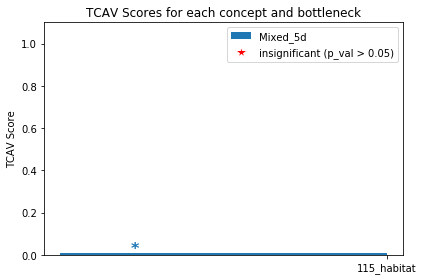

In [0]:
utils_plot.plot_results(results,num_random_exp=2)

In [0]:
target = '115' #bumblebee
working_dir = './tcav_class_test' + target
activation_dir =  working_dir + '/activations/'
cav_dir = working_dir + '/cavs/'
utils.make_dir_if_not_exists(working_dir)     
utils.make_dir_if_not_exists(activation_dir)
utils.make_dir_if_not_exists(cav_dir)
act_generator = act_gen.ImageActivationGenerator(mymodel, source_dir, activation_dir, max_examples=100)
# tf.logging.set_verbosity(0)
tf.logging.set_verbosity(tf.logging.INFO)
concepts = ['127'] #similar bumblebee
mytcav = TCAV(target,concepts,bottlenecks,act_generator,alphas,cav_dir=cav_dir,num_random_exp=2)
results = mytcav.run()
np.save('results_%s.npy'%target,results)

INFO:tensorflow:Mixed_5b ['127', 'random500_0'] 115 0.1
INFO:tensorflow:Mixed_5b ['127', 'random500_1'] 115 0.1
INFO:tensorflow:Mixed_5b ['random500_0', 'random500_1'] 115 0.1
INFO:tensorflow:Mixed_5b ['random500_1', 'random500_0'] 115 0.1
INFO:tensorflow:TCAV will 4 params
INFO:tensorflow:running 4 params
INFO:tensorflow:Running param 0 of 4
INFO:tensorflow:running 115 ['127', 'random500_0']
INFO:tensorflow:./tcav_class_test115/activations/acts_127_Mixed_5b does not exist, Making one...
INFO:tensorflow:./tcav_class_test115/activations/acts_random500_0_Mixed_5b does not exist, Making one...
INFO:tensorflow:./tcav_class_test115/activations/acts_115_Mixed_5b does not exist, Making one...
INFO:tensorflow:Training CAV ['127', 'random500_0'] - Mixed_5b alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'127': 0.47058823529411764, 'random500_0': 0.6875, 'overall': 0.5757575757575758}
INFO:tensorflow:Running param 1 of 4
INFO:tensorflow:running 115 ['127', 'rando

Class = 115
  Concept = 127
    Bottleneck = Mixed_5b. TCAV Score = 0.41 (+- 0.04), random was 0.53 (+- 0.07). p-val = 0.220 (not significant)


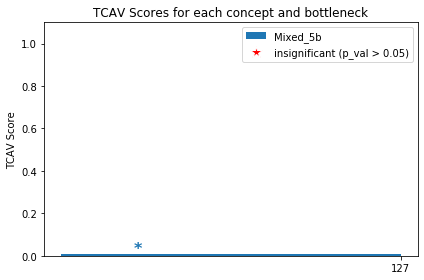

In [0]:
utils_plot.plot_results(results,num_random_exp=2)

# k

In [0]:
target = '127' #bumblebee
working_dir = './tcav_class_test' + target
activation_dir =  working_dir + '/activations/'
cav_dir = working_dir + '/cavs/'
utils.make_dir_if_not_exists(working_dir)     
utils.make_dir_if_not_exists(activation_dir)
utils.make_dir_if_not_exists(cav_dir)
act_generator = act_gen.ImageActivationGenerator(mymodel, source_dir, activation_dir, max_examples=100)
# tf.logging.set_verbosity(0)
tf.logging.set_verbosity(tf.logging.INFO)
concepts = ['115_habitat'] #115  habitat
mytcav = TCAV(target,concepts,bottlenecks,act_generator,alphas,cav_dir=cav_dir,num_random_exp=2)
results = mytcav.run()
np.save('results_%s.npy'%target,results)




INFO:tensorflow:Mixed_5b ['115_habitat', 'random500_0'] 127 0.1
INFO:tensorflow:Mixed_5b ['115_habitat', 'random500_1'] 127 0.1
INFO:tensorflow:Mixed_5b ['random500_0', 'random500_1'] 127 0.1
INFO:tensorflow:Mixed_5b ['random500_1', 'random500_0'] 127 0.1
INFO:tensorflow:TCAV will 4 params
INFO:tensorflow:running 4 params
INFO:tensorflow:Running param 0 of 4
INFO:tensorflow:running 127 ['115_habitat', 'random500_0']

INFO:tensorflow:./tcav_class_test127/activations/acts_115_habitat_Mixed_5b does not exist, Making one...
INFO:tensorflow:./tcav_class_test127/activations/acts_random500_0_Mixed_5b does not exist, Making one...
INFO:tensorflow:./tcav_class_test127/activations/acts_127_Mixed_5b does not exist, Making one...
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io

Class = 127
  Concept = 115_habitat
    Bottleneck = Mixed_5b. TCAV Score = 0.46 (+- 0.14), random was 0.51 (+- 0.03). p-val = 0.790 (not significant)


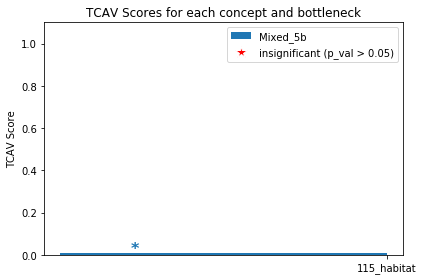

In [0]:
utils_plot.plot_results(results,num_random_exp=2)

In [0]:
target = '25' 
working_dir = './tcav_class_test' + target
activation_dir =  working_dir + '/activations/'
cav_dir = working_dir + '/cavs/'
utils.make_dir_if_not_exists(working_dir)     
utils.make_dir_if_not_exists(activation_dir)
utils.make_dir_if_not_exists(cav_dir)
act_generator = act_gen.ImageActivationGenerator(mymodel, source_dir, activation_dir, max_examples=100)
concepts = [target + '_habitat']
# tf.logging.set_verbosity(0)
tf.logging.set_verbosity(tf.logging.INFO)
mytcav2 = TCAV(target,concepts,bottlenecks,act_generator,alphas,cav_dir=cav_dir,num_random_exp=2)
results2 = mytcav2.run()
np.save('results_%s.npy'%target,results2)

INFO:tensorflow:Mixed_5b ['25_habitat', 'random500_0'] 25 0.1
INFO:tensorflow:Mixed_5b ['25_habitat', 'random500_1'] 25 0.1
INFO:tensorflow:Mixed_5b ['random500_0', 'random500_1'] 25 0.1
INFO:tensorflow:Mixed_5b ['random500_1', 'random500_0'] 25 0.1
INFO:tensorflow:TCAV will 4 params
INFO:tensorflow:running 4 params
INFO:tensorflow:Running param 0 of 4
INFO:tensorflow:running 25 ['25_habitat', 'random500_0']
INFO:tensorflow:./tcav_class_test25/activations/acts_25_habitat_Mixed_5b does not exist, Making one...
INFO:tensorflow:./tcav_class_test25/activations/acts_random500_0_Mixed_5b does not exist, Making one...
INFO:tensorflow:./tcav_class_test25/activations/acts_25_Mixed_5b does not exist, Making one...
INFO:tensorflow:Training CAV ['25_habitat', 'random500_0'] - Mixed_5b alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'25_habitat': 0.3333333333333333, 'random500_0': 1.0, 'overall': 0.6666666666666666}
INFO:tensorflow:Running param 1 of 4
INFO:tensorfl

Class = 25
  Concept = 25_habitat
    Bottleneck = Mixed_5b. TCAV Score = 0.24 (+- 0.11), random was 0.48 (+- 0.06). p-val = 0.196 (not significant)


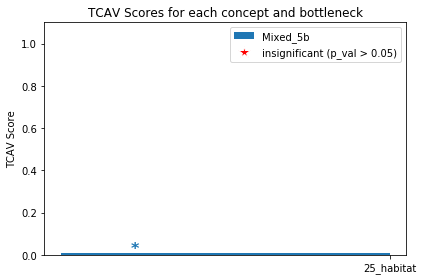

In [0]:
utils_plot.plot_results(results2,num_random_exp=2)

In [0]:
target = '86' #leopard boi!! 
working_dir = './tcav_class_test' + target
activation_dir =  working_dir + '/activations/'
cav_dir = working_dir + '/cavs/'
utils.make_dir_if_not_exists(working_dir)     
utils.make_dir_if_not_exists(activation_dir)
utils.make_dir_if_not_exists(cav_dir)
act_generator = act_gen.ImageActivationGenerator(mymodel, source_dir, activation_dir, max_examples=100)
concepts = [target + '_habitat']
# tf.logging.set_verbosity(0)
tf.logging.set_verbosity(tf.logging.INFO)
mytcav3 = TCAV(target,concepts,bottlenecks,act_generator,alphas,cav_dir=cav_dir,num_random_exp=2)
results3 = mytcav3.run()
np.save('results_%s.npy'%target,results3)

INFO:tensorflow:Mixed_5b ['86_habitat', 'random500_0'] 86 0.1
INFO:tensorflow:Mixed_5b ['86_habitat', 'random500_1'] 86 0.1
INFO:tensorflow:Mixed_5b ['random500_0', 'random500_1'] 86 0.1
INFO:tensorflow:Mixed_5b ['random500_1', 'random500_0'] 86 0.1
INFO:tensorflow:TCAV will 4 params
INFO:tensorflow:running 4 params
INFO:tensorflow:Running param 0 of 4
INFO:tensorflow:running 86 ['86_habitat', 'random500_0']
INFO:tensorflow:./tcav_class_test86/activations/acts_86_habitat_Mixed_5b does not exist, Making one...
INFO:tensorflow:./tcav_class_test86/activations/acts_random500_0_Mixed_5b does not exist, Making one...
INFO:tensorflow:./tcav_class_test86/activations/acts_86_Mixed_5b does not exist, Making one...
INFO:tensorflow:Training CAV ['86_habitat', 'random500_0'] - Mixed_5b alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'86_habitat': 1.0, 'random500_0': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 1 of 4
INFO:tensorflow:running 86 ['86_habitat', '

Class = 86
  Concept = 86_habitat
    Bottleneck = Mixed_5b. TCAV Score = 0.35 (+- 0.04), random was 0.47 (+- 0.29). p-val = 0.722 (not significant)


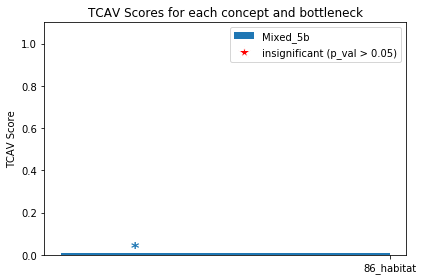

In [0]:
utils_plot.plot_results(results3,num_random_exp=2)

# Colors

In [0]:
target = '115' #bumblebee
working_dir = './tcav_class_test' + target
activation_dir =  working_dir + '/activations/'
cav_dir = working_dir + '/cavs/'
utils.make_dir_if_not_exists(working_dir)     
utils.make_dir_if_not_exists(activation_dir)
utils.make_dir_if_not_exists(cav_dir)
act_generator = act_gen.ImageActivationGenerator(mymodel, source_dir, activation_dir, max_examples=100)
concepts = colors
# tf.logging.set_verbosity(0)
tf.logging.set_verbosity(tf.logging.INFO)
mytcav = TCAV(target,concepts,bottlenecks,act_generator,alphas,cav_dir=cav_dir,num_random_exp=2)
results = mytcav.run()
np.save('results_%s.npy'%target,results)

INFO:tensorflow:Mixed_5b ['green', 'random500_0'] 115 0.1
INFO:tensorflow:Mixed_5b ['green', 'random500_1'] 115 0.1
INFO:tensorflow:Mixed_5b ['red', 'random500_0'] 115 0.1
INFO:tensorflow:Mixed_5b ['red', 'random500_1'] 115 0.1
INFO:tensorflow:Mixed_5b ['gray', 'random500_0'] 115 0.1
INFO:tensorflow:Mixed_5b ['gray', 'random500_1'] 115 0.1
INFO:tensorflow:Mixed_5b ['brown', 'random500_0'] 115 0.1
INFO:tensorflow:Mixed_5b ['brown', 'random500_1'] 115 0.1
INFO:tensorflow:Mixed_5b ['random500_0', 'random500_1'] 115 0.1
INFO:tensorflow:Mixed_5b ['random500_1', 'random500_0'] 115 0.1
INFO:tensorflow:TCAV will 10 params
INFO:tensorflow:running 10 params
INFO:tensorflow:Running param 0 of 10
INFO:tensorflow:running 115 ['green', 'random500_0']
INFO:tensorflow:./tcav_class_test115/activations/acts_green_Mixed_5b does not exist, Making one...
INFO:tensorflow:./tcav_class_test115/activations/acts_random500_0_Mixed_5b does not exist, Making one...
INFO:tensorflow:./tcav_class_test115/activations/

Class = 115
  Concept = green
    Bottleneck = Mixed_5b. TCAV Score = 0.43 (+- 0.02), random was 0.48 (+- 0.02). p-val = 0.159 (not significant)
  Concept = red
    Bottleneck = Mixed_5b. TCAV Score = 0.48 (+- 0.02), random was 0.48 (+- 0.02). p-val = 0.860 (not significant)
  Concept = gray
    Bottleneck = Mixed_5b. TCAV Score = 0.43 (+- 0.01), random was 0.48 (+- 0.02). p-val = 0.087 (not significant)
  Concept = brown
    Bottleneck = Mixed_5b. TCAV Score = 0.47 (+- 0.00), random was 0.48 (+- 0.02). p-val = 0.423 (not significant)


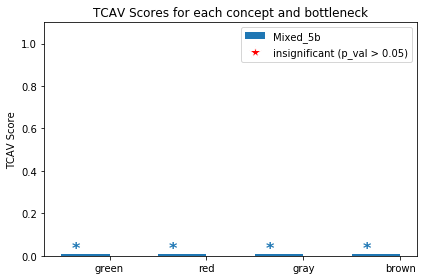

In [0]:
utils_plot.plot_results(results,num_random_exp=2)

In [0]:
target = '86'
bottlenecks = ['Conv2d_2a_3x3']
working_dir = './tcav_class_test' + target
activation_dir =  working_dir + '/activations/'
cav_dir = working_dir + '/cavs/'
utils.make_dir_if_not_exists(working_dir)     
utils.make_dir_if_not_exists(activation_dir)
utils.make_dir_if_not_exists(cav_dir)
act_generator = act_gen.ImageActivationGenerator(mymodel, source_dir, activation_dir, max_examples=100)
concepts = colors
# tf.logging.set_verbosity(0)
tf.logging.set_verbosity(tf.logging.INFO)
mytcav = TCAV(target,concepts,bottlenecks,act_generator,alphas,cav_dir=cav_dir,num_random_exp=2)
results = mytcav.run()
np.save('results_%s.npy'%target,results)


INFO:tensorflow:Conv2d_2a_3x3 ['green', 'random500_0'] 86 0.1
INFO:tensorflow:Conv2d_2a_3x3 ['green', 'random500_1'] 86 0.1
INFO:tensorflow:Conv2d_2a_3x3 ['red', 'random500_0'] 86 0.1
INFO:tensorflow:Conv2d_2a_3x3 ['red', 'random500_1'] 86 0.1
INFO:tensorflow:Conv2d_2a_3x3 ['gray', 'random500_0'] 86 0.1
INFO:tensorflow:Conv2d_2a_3x3 ['gray', 'random500_1'] 86 0.1
INFO:tensorflow:Conv2d_2a_3x3 ['brown', 'random500_0'] 86 0.1
INFO:tensorflow:Conv2d_2a_3x3 ['brown', 'random500_1'] 86 0.1
INFO:tensorflow:Conv2d_2a_3x3 ['random500_0', 'random500_1'] 86 0.1
INFO:tensorflow:Conv2d_2a_3x3 ['random500_1', 'random500_0'] 86 0.1
INFO:tensorflow:TCAV will 10 params
INFO:tensorflow:running 10 params
INFO:tensorflow:Running param 0 of 10
INFO:tensorflow:running 86 ['green', 'random500_0']
INFO:tensorflow:Loaded ./tcav_class_test86/activations/acts_green_Conv2d_2a_3x3 shape (3, 32, 147, 147)
INFO:tensorflow:Loaded ./tcav_class_test86/activations/acts_random500_0_Conv2d_2a_3x3 shape (50, 32, 147, 147

Class = 86
  Concept = green
    Bottleneck = Conv2d_2a_3x3. TCAV Score = 0.29 (+- 0.02), random was 0.55 (+- 0.01). p-val = 0.009 (significant)
  Concept = red
    Bottleneck = Conv2d_2a_3x3. TCAV Score = 0.42 (+- 0.05), random was 0.55 (+- 0.01). p-val = 0.103 (not significant)
  Concept = gray
    Bottleneck = Conv2d_2a_3x3. TCAV Score = 0.66 (+- 0.01), random was 0.55 (+- 0.01). p-val = 0.009 (significant)
  Concept = brown
    Bottleneck = Conv2d_2a_3x3. TCAV Score = 0.40 (+- 0.08), random was 0.55 (+- 0.01). p-val = 0.220 (not significant)


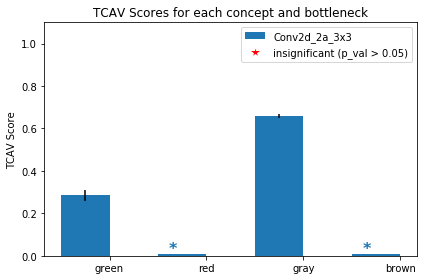

In [0]:
utils_plot.plot_results(results,num_random_exp=2)

In [0]:
target = '25'
working_dir = './tcav_class_test' + target
activation_dir =  working_dir + '/activations/'
cav_dir = working_dir + '/cavs/'
utils.make_dir_if_not_exists(working_dir)     
utils.make_dir_if_not_exists(activation_dir)
utils.make_dir_if_not_exists(cav_dir)
act_generator = act_gen.ImageActivationGenerator(mymodel, source_dir, activation_dir, max_examples=100)
concepts = colors
# tf.logging.set_verbosity(0)
tf.logging.set_verbosity(tf.logging.INFO)
mytcav = TCAV(target,concepts,bottlenecks,act_generator,alphas,cav_dir=cav_dir,num_random_exp=2)
results = mytcav.run()
np.save('results_%s.npy'%target,results)

INFO:tensorflow:Conv2d_2a_3x3 ['green', 'random500_0'] 25 0.1
INFO:tensorflow:Conv2d_2a_3x3 ['green', 'random500_1'] 25 0.1
INFO:tensorflow:Conv2d_2a_3x3 ['red', 'random500_0'] 25 0.1
INFO:tensorflow:Conv2d_2a_3x3 ['red', 'random500_1'] 25 0.1
INFO:tensorflow:Conv2d_2a_3x3 ['gray', 'random500_0'] 25 0.1
INFO:tensorflow:Conv2d_2a_3x3 ['gray', 'random500_1'] 25 0.1
INFO:tensorflow:Conv2d_2a_3x3 ['brown', 'random500_0'] 25 0.1
INFO:tensorflow:Conv2d_2a_3x3 ['brown', 'random500_1'] 25 0.1
INFO:tensorflow:Conv2d_2a_3x3 ['random500_0', 'random500_1'] 25 0.1
INFO:tensorflow:Conv2d_2a_3x3 ['random500_1', 'random500_0'] 25 0.1
INFO:tensorflow:TCAV will 10 params
INFO:tensorflow:running 10 params
INFO:tensorflow:Running param 0 of 10
INFO:tensorflow:running 25 ['green', 'random500_0']
INFO:tensorflow:./tcav_class_test25/activations/acts_green_Conv2d_2a_3x3 does not exist, Making one...
INFO:tensorflow:./tcav_class_test25/activations/acts_random500_0_Conv2d_2a_3x3 does not exist, Making one...
IN

Class = 25
  Concept = green
    Bottleneck = Conv2d_2a_3x3. TCAV Score = 0.86 (+- 0.01), random was 0.43 (+- 0.08). p-val = 0.029 (significant)
  Concept = red
    Bottleneck = Conv2d_2a_3x3. TCAV Score = 0.21 (+- 0.12), random was 0.43 (+- 0.08). p-val = 0.255 (not significant)
  Concept = gray
    Bottleneck = Conv2d_2a_3x3. TCAV Score = 0.61 (+- 0.12), random was 0.43 (+- 0.08). p-val = 0.342 (not significant)
  Concept = brown
    Bottleneck = Conv2d_2a_3x3. TCAV Score = 0.23 (+- 0.15), random was 0.43 (+- 0.08). p-val = 0.347 (not significant)


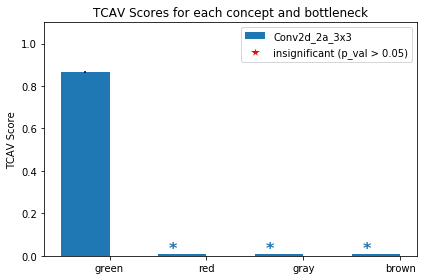

In [0]:
utils_plot.plot_results(results,num_random_exp=2)



The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Class = 134
  Concept = green
    Bottleneck = Conv2d_2a_3x3. TCAV Score = 0.62 (+- 0.00), random was 0.52 (+- 0.05). p-val = 0.159 (not significant)
  Concept = red
    Bottleneck = Conv2d_2a_3x3. TCAV Score = 0.68 (+- 0.06), random was 0.52 (+- 0.05). p-val = 0.161 (not significant)
  Concept = gray
    Bottleneck = Conv2d_2a_3x3. TCAV Score = 0.63 (+- 0.03), random was 0.52 (+- 0.05). p-val = 0.176 (not significant)
  Concept = brown
    Bottleneck = Conv2d_2a_3x3. TCAV Score = 0.67 (+- 0.07), random was 0.52 (+- 0.05). p-val = 0.204 (not significant)


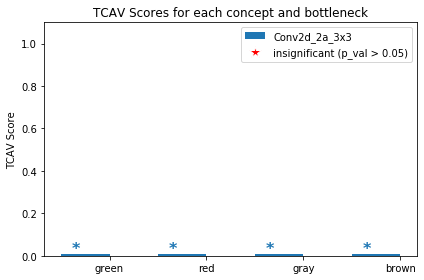

Class = 38
  Concept = green
    Bottleneck = Conv2d_2a_3x3. TCAV Score = 0.12 (+- 0.02), random was 0.48 (+- 0.08). p-val = 0.056 (not significant)
  Concept = red
    Bottleneck = Conv2d_2a_3x3. TCAV Score = 0.45 (+- 0.07), random was 0.48 (+- 0.08). p-val = 0.744 (not significant)
  Concept = gray
    Bottleneck = Conv2d_2a_3x3. TCAV Score = 0.56 (+- 0.05), random was 0.48 (+- 0.08). p-val = 0.512 (not significant)
  Concept = brown
    Bottleneck = Conv2d_2a_3x3. TCAV Score = 0.33 (+- 0.15), random was 0.48 (+- 0.08). p-val = 0.461 (not significant)


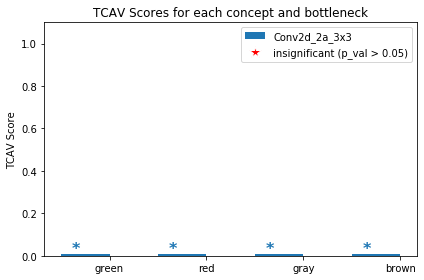

In [0]:
# res = {}
bottlenecks = ['Conv2d_2a_3x3']

for t in [134,38]:
  target = str(t)
  working_dir = './tcav_class_test' + target
  activation_dir =  working_dir + '/activations/'
  cav_dir = working_dir + '/cavs/'
  utils.make_dir_if_not_exists(working_dir)     
  utils.make_dir_if_not_exists(activation_dir)
  utils.make_dir_if_not_exists(cav_dir)
  act_generator = act_gen.ImageActivationGenerator(mymodel, source_dir, activation_dir, max_examples=100)
  concepts = colors
  # tf.logging.set_verbosity(0)
  tf.logging.set_verbosity(tf.logging.WARN)
  mytcav = TCAV(target,concepts,bottlenecks,act_generator,alphas,cav_dir=cav_dir,num_random_exp=2)
  results = mytcav.run()
  utils_plot.plot_results(results,num_random_exp=2)
  res[target] = results



The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Class = 54
  Concept = green
    Bottleneck = Conv2d_2a_3x3. TCAV Score = 0.67 (+- 0.03), random was 0.47 (+- 0.04). p-val = 0.062 (not significant)
  Concept = red
    Bottleneck = Conv2d_2a_3x3. TCAV Score = 0.54 (+- 0.02), random was 0.47 (+- 0.04). p-val = 0.245 (not significant)
  Concept = gray
    Bottleneck = Conv2d_2a_3x3. TCAV Score = 0.48 (+- 0.06), random was 0.47 (+- 0.04). p-val = 0.892 (not significant)
  Concept = brown
    Bottleneck = Conv2d_2a_3x3. TCAV Score = 0.63 (+- 0.03), random was 0.47 (+- 0.04). p-val = 0.078 (not significant)


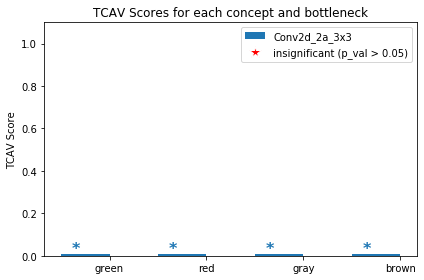


Class = 5
  Concept = green
    Bottleneck = Conv2d_2a_3x3. TCAV Score = 0.44 (+- 0.04), random was 0.47 (+- 0.00). p-val = 0.531 (not significant)
  Concept = red
    Bottleneck = Conv2d_2a_3x3. TCAV Score = 0.15 (+- 0.01), random was 0.47 (+- 0.00). p-val = 0.000 (significant)
  Concept = gray
    Bottleneck = Conv2d_2a_3x3. TCAV Score = 0.61 (+- 0.00), random was 0.47 (+- 0.00). p-val = 0.000 (significant)
  Concept = brown
    Bottleneck = Conv2d_2a_3x3. TCAV Score = 0.32 (+- 0.05), random was 0.47 (+- 0.00). p-val = 0.095 (not significant)


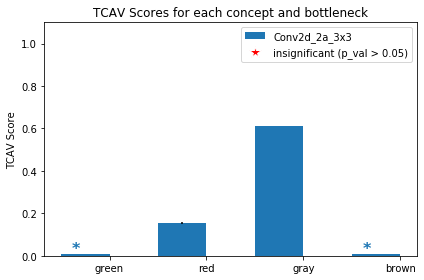

In [0]:
# res = {}
bottlenecks = ['Conv2d_2a_3x3']

for t in [54,5]:
  target = str(t)
  working_dir = './tcav_class_test' + target
  activation_dir =  working_dir + '/activations/'
  cav_dir = working_dir + '/cavs/'
  utils.make_dir_if_not_exists(working_dir)     
  utils.make_dir_if_not_exists(activation_dir)
  utils.make_dir_if_not_exists(cav_dir)
  act_generator = act_gen.ImageActivationGenerator(mymodel, source_dir, activation_dir, max_examples=100)
  concepts = colors
  # tf.logging.set_verbosity(0)
  tf.logging.set_verbosity(tf.logging.WARN)
  mytcav = TCAV(target,concepts,bottlenecks,act_generator,alphas,cav_dir=cav_dir,num_random_exp=2)
  results = mytcav.run()
  utils_plot.plot_results(results,num_random_exp=2)

# Habitats




INFO:tensorflow:Conv2d_2a_3x3 ['54_crops', 'random500_0'] 54 0.1
INFO:tensorflow:Conv2d_2a_3x3 ['54_crops', 'random500_1'] 54 0.1
INFO:tensorflow:Conv2d_2a_3x3 ['random500_0', 'random500_1'] 54 0.1
INFO:tensorflow:Conv2d_2a_3x3 ['random500_1', 'random500_0'] 54 0.1
INFO:tensorflow:Mixed_5b ['54_crops', 'random500_0'] 54 0.1
INFO:tensorflow:Mixed_5b ['54_crops', 'random500_1'] 54 0.1
INFO:tensorflow:Mixed_5b ['random500_0', 'random500_1'] 54 0.1
INFO:tensorflow:Mixed_5b ['random500_1', 'random500_0'] 54 0.1
INFO:tensorflow:Mixed_7b ['54_crops', 'random500_0'] 54 0.1
INFO:tensorflow:Mixed_7b ['54_crops', 'random500_1'] 54 0.1
INFO:tensorflow:Mixed_7b ['random500_0', 'random500_1'] 54 0.1
INFO:tensorflow:Mixed_7b ['random500_1', 'random500_0'] 54 0.1
INFO:tensorflow:fc ['54_crops', 'random500_0'] 54 0.1
INFO:tensorflow:fc ['54_crops', 'random500_1'] 54 0.1
INFO:tensorflow:fc ['random500_0', 'random500_1'] 54 0.1
INFO:tensorflow:fc ['random500_1', 'random500_0'] 54 0.1
INFO:tensorflow:T

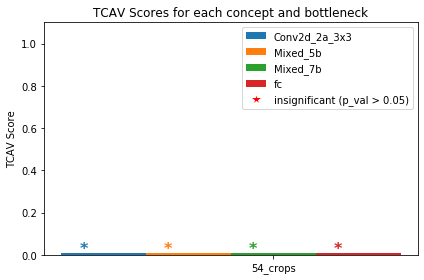

In [0]:
bottlenecks = ['Conv2d_2a_3x3','Mixed_5b','Mixed_7b','fc']
for t in [54]:
  target = str(t)
  working_dir = './tcav_class_test' + target
  activation_dir =  working_dir + '/activations/'
  cav_dir = working_dir + '/cavs/'
  utils.make_dir_if_not_exists(working_dir)     
  utils.make_dir_if_not_exists(activation_dir)
  utils.make_dir_if_not_exists(cav_dir)
  act_generator = act_gen.ImageActivationGenerator(mymodel, source_dir, activation_dir, max_examples=100)
  habitat_str = target +'_crops'
  concepts = [habitat_str]
  tf.logging.set_verbosity(tf.logging.INFO)
  mytcav = TCAV(target,concepts,bottlenecks,act_generator,alphas,cav_dir=cav_dir,num_random_exp=2)
  results = mytcav.run()
  utils_plot.plot_results(results,num_random_exp=2)



INFO:tensorflow:Conv2d_2a_3x3 ['5_crops', 'random500_0'] 5 0.1
INFO:tensorflow:Conv2d_2a_3x3 ['5_crops', 'random500_1'] 5 0.1
INFO:tensorflow:Conv2d_2a_3x3 ['random500_0', 'random500_1'] 5 0.1
INFO:tensorflow:Conv2d_2a_3x3 ['random500_1', 'random500_0'] 5 0.1
INFO:tensorflow:Mixed_5b ['5_crops', 'random500_0'] 5 0.1
INFO:tensorflow:Mixed_5b ['5_crops', 'random500_1'] 5 0.1
INFO:tensorflow:Mixed_5b ['random500_0', 'random500_1'] 5 0.1
INFO:tensorflow:Mixed_5b ['random500_1', 'random500_0'] 5 0.1
INFO:tensorflow:Mixed_7b ['5_crops', 'random500_0'] 5 0.1
INFO:tensorflow:Mixed_7b ['5_crops', 'random500_1'] 5 0.1
INFO:tensorflow:Mixed_7b ['random500_0', 'random500_1'] 5 0.1
INFO:tensorflow:Mixed_7b ['random500_1', 'random500_0'] 5 0.1
INFO:tensorflow:fc ['5_crops', 'random500_0'] 5 0.1
INFO:tensorflow:fc ['5_crops', 'random500_1'] 5 0.1
INFO:tensorflow:fc ['random500_0', 'random500_1'] 5 0.1
INFO:tensorflow:fc ['random500_1', 'random500_0'] 5 0.1
INFO:tensorflow:TCAV will 16 params
INFO:t

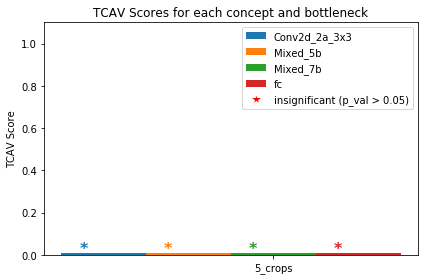

In [0]:
bottlenecks = ['Conv2d_2a_3x3','Mixed_5b','Mixed_7b','fc']
for t in [5]:
  target = str(t)
  working_dir = './tcav_class_test' + target
  activation_dir =  working_dir + '/activations/'
  cav_dir = working_dir + '/cavs/'
  utils.make_dir_if_not_exists(working_dir)     
  utils.make_dir_if_not_exists(activation_dir)
  utils.make_dir_if_not_exists(cav_dir)
  act_generator = act_gen.ImageActivationGenerator(mymodel, source_dir, activation_dir, max_examples=100)
  habitat_str = target +'_crops'
  concepts = [habitat_str]
  tf.logging.set_verbosity(tf.logging.INFO)
  mytcav = TCAV(target,concepts,bottlenecks,act_generator,alphas,cav_dir=cav_dir,num_random_exp=2)
  results = mytcav.run()
  utils_plot.plot_results(results,num_random_exp=2)

INFO:tensorflow:Conv2d_2a_3x3 ['154_crops', 'random500_0'] 154 0.1
INFO:tensorflow:Conv2d_2a_3x3 ['154_crops', 'random500_1'] 154 0.1
INFO:tensorflow:Conv2d_2a_3x3 ['random500_0', 'random500_1'] 154 0.1
INFO:tensorflow:Conv2d_2a_3x3 ['random500_1', 'random500_0'] 154 0.1
INFO:tensorflow:Mixed_5b ['154_crops', 'random500_0'] 154 0.1
INFO:tensorflow:Mixed_5b ['154_crops', 'random500_1'] 154 0.1
INFO:tensorflow:Mixed_5b ['random500_0', 'random500_1'] 154 0.1
INFO:tensorflow:Mixed_5b ['random500_1', 'random500_0'] 154 0.1
INFO:tensorflow:Mixed_7b ['154_crops', 'random500_0'] 154 0.1
INFO:tensorflow:Mixed_7b ['154_crops', 'random500_1'] 154 0.1
INFO:tensorflow:Mixed_7b ['random500_0', 'random500_1'] 154 0.1
INFO:tensorflow:Mixed_7b ['random500_1', 'random500_0'] 154 0.1
INFO:tensorflow:fc ['154_crops', 'random500_0'] 154 0.1
INFO:tensorflow:fc ['154_crops', 'random500_1'] 154 0.1
INFO:tensorflow:fc ['random500_0', 'random500_1'] 154 0.1
INFO:tensorflow:fc ['random500_1', 'random500_0'] 154 

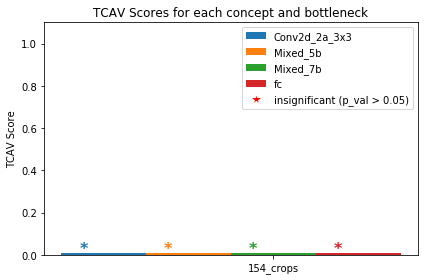

In [0]:
bottlenecks = ['Conv2d_2a_3x3','Mixed_5b','Mixed_7b','fc']
for t in [154]:
  target = str(t)
  working_dir = './tcav_class_test' + target
  activation_dir =  working_dir + '/activations/'
  cav_dir = working_dir + '/cavs/'
  utils.make_dir_if_not_exists(working_dir)     
  utils.make_dir_if_not_exists(activation_dir)
  utils.make_dir_if_not_exists(cav_dir)
  act_generator = act_gen.ImageActivationGenerator(mymodel, source_dir, activation_dir, max_examples=100)
  habitat_str = target +'_crops'
  concepts = [habitat_str]
  tf.logging.set_verbosity(tf.logging.INFO)
  mytcav = TCAV(target,concepts,bottlenecks,act_generator,alphas,cav_dir=cav_dir,num_random_exp=2)
  results = mytcav.run()
  utils_plot.plot_results(results,num_random_exp=2)

In [0]:
bottlenecks = ['Conv2d_2a_3x3','Mixed_5b','Mixed_7b','fc']
for t in [134]:
  target = str(t)
  working_dir = './tcav_class_test' + target
  activation_dir =  working_dir + '/activations/'
  cav_dir = working_dir + '/cavs/'
  utils.make_dir_if_not_exists(working_dir)     
  utils.make_dir_if_not_exists(activation_dir)
  utils.make_dir_if_not_exists(cav_dir)
  act_generator = act_gen.ImageActivationGenerator(mymodel, source_dir, activation_dir, max_examples=100)
  habitat_str = target +'_crops'
  concepts = [habitat_str]
  tf.logging.set_verbosity(tf.logging.INFO)
  mytcav = TCAV(target,concepts,bottlenecks,act_generator,alphas,cav_dir=cav_dir,num_random_exp=2)
  results = mytcav.run()
  utils_plot.plot_results(results,num_random_exp=2)

NameError: ignored

In [0]:
bottlenecks = ['Conv2d_2a_3x3','Mixed_5b','Mixed_7b','fc']
for t in [158]:
  target = str(t)
  working_dir = './tcav_class_test' + target
  activation_dir =  working_dir + '/activations/'
  cav_dir = working_dir + '/cavs/'
  utils.make_dir_if_not_exists(working_dir)     
  utils.make_dir_if_not_exists(activation_dir)
  utils.make_dir_if_not_exists(cav_dir)
  act_generator = act_gen.ImageActivationGenerator(mymodel, source_dir, activation_dir, max_examples=100)
  habitat_str = target +'_crops'
  concepts = [habitat_str]
  tf.logging.set_verbosity(tf.logging.INFO)
  mytcav = TCAV(target,concepts,bottlenecks,act_generator,alphas,cav_dir=cav_dir,num_random_exp=2)
  results = mytcav.run()
  utils_plot.plot_results(results,num_random_exp=2)


INFO:tensorflow:Conv2d_2a_3x3 ['158_crops', 'random500_0'] 158 0.1
INFO:tensorflow:Conv2d_2a_3x3 ['158_crops', 'random500_1'] 158 0.1
INFO:tensorflow:Conv2d_2a_3x3 ['random500_0', 'random500_1'] 158 0.1
INFO:tensorflow:Conv2d_2a_3x3 ['random500_1', 'random500_0'] 158 0.1
INFO:tensorflow:Mixed_5b ['158_crops', 'random500_0'] 158 0.1
INFO:tensorflow:Mixed_5b ['158_crops', 'random500_1'] 158 0.1
INFO:tensorflow:Mixed_5b ['random500_0', 'random500_1'] 158 0.1
INFO:tensorflow:Mixed_5b ['random500_1', 'random500_0'] 158 0.1
INFO:tensorflow:Mixed_7b ['158_crops', 'random500_0'] 158 0.1
INFO:tensorflow:Mixed_7b ['158_crops', 'random500_1'] 158 0.1
INFO:tensorflow:Mixed_7b ['random500_0', 'random500_1'] 158 0.1
INFO:tensorflow:Mixed_7b ['random500_1', 'random500_0'] 158 0.1
INFO:tensorflow:fc ['158_crops', 'random500_0'] 158 0.1
INFO:tensorflow:fc ['158_crops', 'random500_1'] 158 0.1
INFO:tensorflow:fc ['random500_0', 'random500_1'] 158 0.1
INFO:tensorflow:fc ['random500_1', 'random500_0'] 158

# Patterns

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Class = 5
  Concept = 5_pattern
    Bottleneck = Conv2d_2a_3x3. TCAV Score = 0.47 (+- 0.02), random was 0.53 (+- 0.07). p-val = 0.592 (not significant)
    Bottleneck = Mixed_5b. TCAV Score = 0.20 (+- 0.00), random was 0.53 (+- 0.23). p-val = 0.285 (not significant)
    Bottleneck = Mixed_7b. TCAV Score = 0.20 (+- 0.05), random was 0.65 (+- 0.05). p-val = 0.024 (significant)
    Bottleneck = fc. TCAV Score = 1.00 (+- 0.00), random was 0.00 (+- 0.00). p-val = 0.000 (significant)


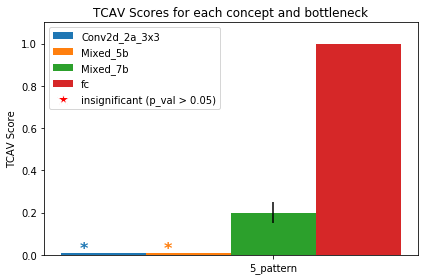

Class = 158
  Concept = 158_pattern
    Bottleneck = Conv2d_2a_3x3. TCAV Score = 0.48 (+- 0.08), random was 0.53 (+- 0.23). p-val = 0.853 (not significant)
    Bottleneck = Mixed_5b. TCAV Score = 0.55 (+- 0.00), random was 0.43 (+- 0.02). p-val = 0.038 (significant)
    Bottleneck = Mixed_7b. TCAV Score = 0.38 (+- 0.38), random was 0.82 (+- 0.12). p-val = 0.373 (not significant)
    Bottleneck = fc. TCAV Score = 0.00 (+- 0.00), random was 1.00 (+- 0.00). p-val = 0.000 (significant)


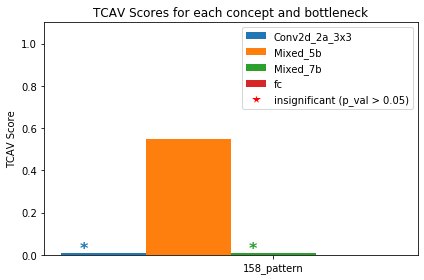

In [0]:
bottlenecks = ['Conv2d_2a_3x3','Mixed_5b','Mixed_7b','fc']
for t in [5,158]:
  target = str(t)
  working_dir = './tcav_class_test' + target
  activation_dir =  working_dir + '/activations/'
  cav_dir = working_dir + '/cavs/'
  utils.make_dir_if_not_exists(working_dir)     
  utils.make_dir_if_not_exists(activation_dir)
  utils.make_dir_if_not_exists(cav_dir)
  act_generator = act_gen.ImageActivationGenerator(mymodel, source_dir, activation_dir, max_examples=100)
  pattern_str = target +'_pattern'
  concepts = [pattern_str]
  tf.logging.set_verbosity(tf.logging.WARN)
  mytcav = TCAV(target,concepts,bottlenecks,act_generator,alphas,cav_dir=cav_dir,num_random_exp=2)
  results = mytcav.run()
  utils_plot.plot_results(results,num_random_exp=2)

# Imagenet places

In [0]:
target = '115' #bumblebee
working_dir = './tcav_class_test' + target
activation_dir =  working_dir + '/activations/'
cav_dir = working_dir + '/cavs/'
utils.make_dir_if_not_exists(working_dir)     
utils.make_dir_if_not_exists(activation_dir)
utils.make_dir_if_not_exists(cav_dir)
act_generator = act_gen.ImageActivationGenerator(mymodel, source_dir, activation_dir, max_examples=100)
concepts = ['mountain','lake','rocks']
# tf.logging.set_verbosity(0)
tf.logging.set_verbosity(tf.logging.INFO)
mytcav = TCAV(target,concepts,bottlenecks,act_generator,alphas,cav_dir=cav_dir,num_random_exp=2)
results = mytcav.run()
np.save('results_%s.npy'%target,results)

INFO:tensorflow:Mixed_5b ['mountain', 'random500_0'] 115 0.1
INFO:tensorflow:Mixed_5b ['mountain', 'random500_1'] 115 0.1
INFO:tensorflow:Mixed_5b ['lake', 'random500_0'] 115 0.1
INFO:tensorflow:Mixed_5b ['lake', 'random500_1'] 115 0.1
INFO:tensorflow:Mixed_5b ['rocks', 'random500_0'] 115 0.1
INFO:tensorflow:Mixed_5b ['rocks', 'random500_1'] 115 0.1
INFO:tensorflow:Mixed_5b ['random500_0', 'random500_1'] 115 0.1
INFO:tensorflow:Mixed_5b ['random500_1', 'random500_0'] 115 0.1
INFO:tensorflow:TCAV will 8 params
INFO:tensorflow:running 8 params
INFO:tensorflow:Running param 0 of 8
INFO:tensorflow:running 115 ['mountain', 'random500_0']
INFO:tensorflow:Loaded ./tcav_class_test115/activations/acts_mountain_Mixed_5b shape (13, 256, 35, 35)
INFO:tensorflow:Loaded ./tcav_class_test115/activations/acts_random500_0_Mixed_5b shape (50, 256, 35, 35)
INFO:tensorflow:Loaded ./tcav_class_test115/activations/acts_115_Mixed_5b shape (100, 256, 35, 35)
INFO:tensorflow:CAV already exists: ./tcav_class_te

KeyboardInterrupt: ignored

In [0]:
utils_plot.plot_results(results,num_random_exp=2)

In [0]:
target = '86'
working_dir = './tcav_class_test' + target
activation_dir =  working_dir + '/activations/'
cav_dir = working_dir + '/cavs/'
utils.make_dir_if_not_exists(working_dir)     
utils.make_dir_if_not_exists(activation_dir)
utils.make_dir_if_not_exists(cav_dir)
act_generator = act_gen.ImageActivationGenerator(mymodel, source_dir, activation_dir, max_examples=100)
concepts = ['mountain','lake','rocks']
# tf.logging.set_verbosity(0)
tf.logging.set_verbosity(tf.logging.INFO)
mytcav = TCAV(target,concepts,bottlenecks,act_generator,alphas,cav_dir=cav_dir,num_random_exp=2)
results = mytcav.run()
np.save('results_%s.npy'%target,results)

INFO:tensorflow:Mixed_5b ['mountain', 'random500_0'] 86 0.1
INFO:tensorflow:Mixed_5b ['mountain', 'random500_1'] 86 0.1
INFO:tensorflow:Mixed_5b ['lake', 'random500_0'] 86 0.1
INFO:tensorflow:Mixed_5b ['lake', 'random500_1'] 86 0.1
INFO:tensorflow:Mixed_5b ['rocks', 'random500_0'] 86 0.1
INFO:tensorflow:Mixed_5b ['rocks', 'random500_1'] 86 0.1
INFO:tensorflow:Mixed_5b ['random500_0', 'random500_1'] 86 0.1
INFO:tensorflow:Mixed_5b ['random500_1', 'random500_0'] 86 0.1
INFO:tensorflow:TCAV will 8 params
INFO:tensorflow:running 8 params
INFO:tensorflow:Running param 0 of 8
INFO:tensorflow:running 86 ['mountain', 'random500_0']

INFO:tensorflow:./tcav_class_test86/activations/acts_mountain_Mixed_5b does not exist, Making one...
INFO:tensorflow:Loaded ./tcav_class_test86/activations/acts_random500_0_Mixed_5b shape (50, 256, 35, 35)
INFO:tensorflow:Loaded ./tcav_class_test86/activations/acts_86_Mixed_5b shape (100, 256, 35, 35)
The TensorFlow contrib module will not be included in TensorFlow

Class = 86
  Concept = mountain
    Bottleneck = Mixed_5b. TCAV Score = 0.32 (+- 0.09), random was 0.47 (+- 0.29). p-val = 0.659 (not significant)
  Concept = lake
    Bottleneck = Mixed_5b. TCAV Score = 0.31 (+- 0.07), random was 0.47 (+- 0.29). p-val = 0.645 (not significant)
  Concept = rocks
    Bottleneck = Mixed_5b. TCAV Score = 0.36 (+- 0.11), random was 0.47 (+- 0.29). p-val = 0.768 (not significant)


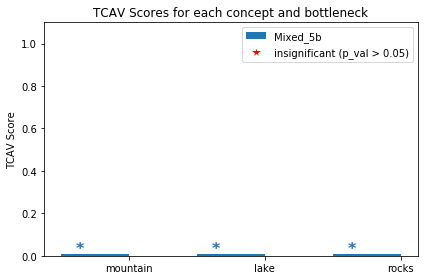

In [0]:
utils_plot.plot_results(results,num_random_exp=2)

In [0]:
target = '25'
working_dir = './tcav_class_test' + target
activation_dir =  working_dir + '/activations/'
cav_dir = working_dir + '/cavs/'
utils.make_dir_if_not_exists(working_dir)     
utils.make_dir_if_not_exists(activation_dir)
utils.make_dir_if_not_exists(cav_dir)
act_generator = act_gen.ImageActivationGenerator(mymodel, source_dir, activation_dir, max_examples=100)
concepts = ['mountain','lake','rocks']
# tf.logging.set_verbosity(0)
tf.logging.set_verbosity(tf.logging.INFO)
mytcav = TCAV(target,concepts,bottlenecks,act_generator,alphas,cav_dir=cav_dir,num_random_exp=2)
results = mytcav.run()
np.save('results_%s.npy'%target,results)

INFO:tensorflow:Mixed_5b ['mountain', 'random500_0'] 25 0.1
INFO:tensorflow:Mixed_5b ['mountain', 'random500_1'] 25 0.1
INFO:tensorflow:Mixed_5b ['lake', 'random500_0'] 25 0.1
INFO:tensorflow:Mixed_5b ['lake', 'random500_1'] 25 0.1
INFO:tensorflow:Mixed_5b ['rocks', 'random500_0'] 25 0.1
INFO:tensorflow:Mixed_5b ['rocks', 'random500_1'] 25 0.1
INFO:tensorflow:Mixed_5b ['random500_0', 'random500_1'] 25 0.1
INFO:tensorflow:Mixed_5b ['random500_1', 'random500_0'] 25 0.1
INFO:tensorflow:TCAV will 8 params
INFO:tensorflow:running 8 params
INFO:tensorflow:Running param 0 of 8
INFO:tensorflow:running 25 ['mountain', 'random500_0']
INFO:tensorflow:./tcav_class_test25/activations/acts_mountain_Mixed_5b does not exist, Making one...
INFO:tensorflow:Loaded ./tcav_class_test25/activations/acts_random500_0_Mixed_5b shape (50, 256, 35, 35)
INFO:tensorflow:Loaded ./tcav_class_test25/activations/acts_25_Mixed_5b shape (100, 256, 35, 35)
INFO:tensorflow:Training CAV ['mountain', 'random500_0'] - Mixed_

Class = 25
  Concept = mountain
    Bottleneck = Mixed_5b. TCAV Score = 0.61 (+- 0.01), random was 0.48 (+- 0.06). p-val = 0.166 (not significant)
  Concept = lake
    Bottleneck = Mixed_5b. TCAV Score = 0.47 (+- 0.07), random was 0.48 (+- 0.06). p-val = 0.924 (not significant)
  Concept = rocks
    Bottleneck = Mixed_5b. TCAV Score = 0.34 (+- 0.02), random was 0.48 (+- 0.06). p-val = 0.157 (not significant)


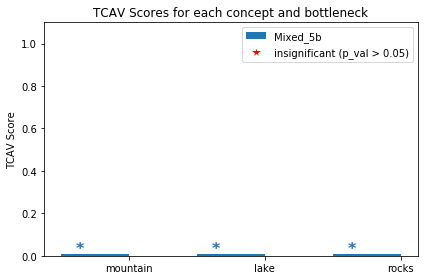

In [0]:
utils_plot.plot_results(results,num_random_exp=2)